### Basic Data Viz

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
df = pd.read_pickle("../data/2017_US_Networks/all_features.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../data/2017_US_Networks/all_features.pkl'

In [98]:
df.forman_curvature = df.forman_curvature.apply(list)
df["forman_mean"] = df.forman_curvature.apply(np.mean)
df["forman_mean_log"] = df.forman_mean.apply(np.log)
df = df.query("total_mortality != -88888 and non_hmo_mortality != -88888 ").copy()

In [99]:
df.columns.values[:10]

array(['hsanum', 'region', 'state', 'medicare_enrollment',
       'total_mortality', 'non_hmo_mortality', 'forman_curvature',
       'n_nodes', 'n_edges', 'density'], dtype=object)

In [100]:
vars_ = [
 'medicare_enrollment',
 'total_mortality',
 'non_hmo_mortality',
 'race_total_pop',
 'race_black_pop',
 'hispanic_total_pop',
 'hispanic_pop',
 'median_hh_income',
 'employment_pop',
 'employment_unemployed_pop',
 'education_pop',
 'education_nohs_pop']

In [118]:
import matplotlib as mpl

In [130]:
cmap = mpl.colormaps["tab10"]

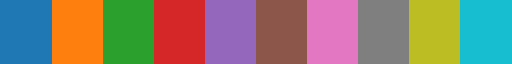

In [131]:
cmap

In [132]:
sorted_regions = sorted(df.region.unique(), key=lambda string: int(string.split()[1]))

In [141]:
def prettify(reg):
    return reg.replace(" ", "")

#### Note
In the following, all but the mortalities are scaled logarithmically, which makes it harder to interpret the plots (especially when axes are mixed). 
Beware that we are not looking at linear correlations here (except when examining mortalities on x and y).

In [ ]:
y_var = "forman_mean"
for idx,reg in enumerate(sorted_regions):
    g = sns.pairplot(data=df.query("region == @reg"), y_vars=[y_var], x_vars=vars_, hue="region", palette=[cmap(idx/len(sorted_regions))])
    for i in [0,3,4,5,6,7,8,9,10,11]:
        g.axes[0,i].set_xscale("log")
    plt.savefig(f"../figures/{prettify(reg)}_{y_var}_vs_population-statistics.pdf", bbox_inches="tight", transparent=True)

In [ ]:
for idx,reg in enumerate(sorted_regions):
    g = sns.pairplot(data=df.query("region == @reg"), y_vars=vars_, x_vars=vars_, hue="region", palette=[cmap(idx/len(sorted_regions))])
    for i in [0,3,4,5,6,7,8,9,10,11]:
        for j in range(11):
            g.axes[j,i].set_xscale("log")
            g.axes[i,j].set_yscale("log")
    plt.savefig(f"../figures/{prettify(reg)}_population-statistics.pdf", bbox_inches="tight", transparent=True)

### Grouping variables

In [87]:
group_prefixes = ["oear", "obd", "cr", "ar", "ptl", "oecr", "oe", "expa", "exp"]
columns_dict = {p:list() for p in group_prefixes}
other_columns = list()
for x in df.columns.values:
    prefix, rest = x.split('_', 1) if "_" in x else (x, "")
    if prefix in group_prefixes:
        columns_dict[prefix].append(x)
    else:
        other_columns.append(x)

In [88]:
other_columns

['hsanum',
 'region',
 'state',
 'medicare_enrollment',
 'total_mortality',
 'non_hmo_mortality',
 'forman_curvature',
 'n_nodes',
 'n_edges',
 'density',
 'assortativity',
 'average_degrees',
 'clustering_coefficients',
 'node_connectivities',
 'degree_correlations',
 'race_total_pop',
 'race_black_pop',
 'hispanic_total_pop',
 'hispanic_pop',
 'median_hh_income',
 'employment_pop',
 'employment_unemployed_pop',
 'education_pop',
 'education_nohs_pop',
 'forman_mean',
 'forman_mean_log']

In [89]:
columns_dict

{'oear': ['oear_pt_asr_ami_anyac',
  'oear_pt_asr_ami_aoervis',
  'oear_pt_asr_ami_mdac',
  'oear_pt_asr_ami_readmit',
  'oear_pt_asr_chf_anyac',
  'oear_pt_asr_chf_aoervis',
  'oear_pt_asr_chf_mdac',
  'oear_pt_asr_chf_readmit',
  'oear_pt_asr_med_anyac',
  'oear_pt_asr_med_aoervis',
  'oear_pt_asr_med_mdac',
  'oear_pt_asr_med_readmit',
  'oear_pt_asr_pn_anyac',
  'oear_pt_asr_pn_aoervis',
  'oear_pt_asr_pn_mdac',
  'oear_pt_asr_pn_readmit',
  'oear_pt_asr_sur_aoervis',
  'oear_pt_asr_sur_mdac',
  'oear_pt_asr_sur_readmit'],
 'obd': ['obd_overall_diab_bloodlip',
  'obd_nonblk_diab_bloodlip',
  'obd_blk_diab_bloodlip',
  'obd_blk_diab_eye',
  'obd_overall_diab_eye',
  'obd_nonblk_diab_eye',
  'obd_overall_diab_hgb',
  'obd_blk_diab_hgb',
  'obd_nonblk_diab_hgb',
  'obd_overall_mam_mam6769',
  'obd_nonblk_mam_mam6769',
  'obd_blk_mam_mam6769',
  'obd_nonblk_ptbjune_amcare2',
  'obd_blk_ptbjune_amcare2',
  'obd_overall_ptbjune_amcare2',
  'obd_pt_asr_ami_anyac',
  'obd_pt_asr_ami_aoervi

In [6]:
# CHOC Network

choc_hsa = 5218
choc_network = "../outputs/santa_ana_graph.pkl"

df = pd.read_pickle("../outputs/all_features2.pkl")

with open(choc_network, "rb") as f:
    G = pickle.load(f)

choc_curvature = df.query("hsanum == @choc_hsa").OR_0.values[0]

In [7]:
pos = nx.circular_layout(G)


degrees = G.degree() #Dict with Node ID, Degree
centrality = nx.degree_centrality(G)
cent_sizes = [centrality[node] * 500 for node in G.nodes()] #Scale Visually



nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])


# Max
weights = [max(G[u][v]['a2b'],G[u][v]['b2a'])/20 for u,v in G.edges()]

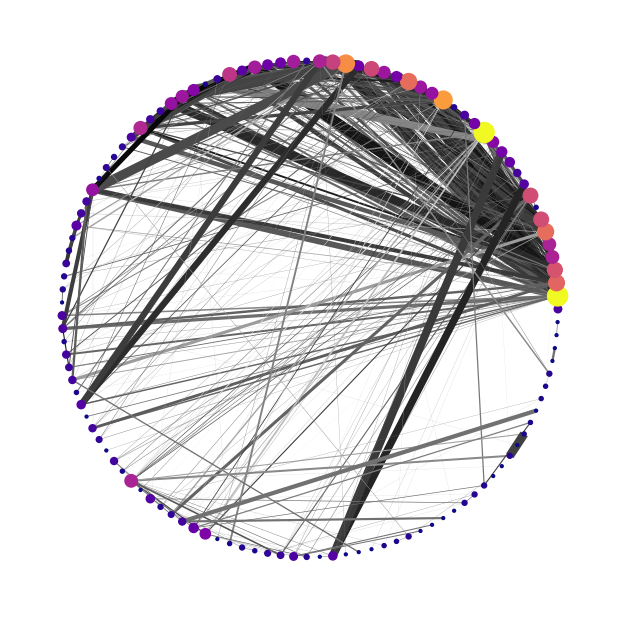

In [8]:
plt.figure(figsize=(6, 6))
nx.draw(G, pos, node_size=cent_sizes, with_labels=False,node_color=n_color, cmap=plt.cm.plasma,width=weights,edge_color=choc_curvature,edge_cmap=plt.cm.Greys)


In [9]:
region_states = {
    "Region 1 - Boston": ["CT", "ME", "MA", "NH", "RI", "VT"],
    "Region 10 - Seattle": ["AK", "ID", "OR", "WA"],
    "Region 2 - New York": ["NJ", "NY", "PR", "VI"],
    "Region 3 - Philadelphia": ["DE", "DC", "MD", "PA", "VA", "WV"],
    "Region 4 - Atlanta": ["AL", "FL", "GA", "KY", "MS", "NC", "SC", "TN"],
    "Region 5 - Chicago": ["IL", "IN", "MI", "MN", "OH", "WI"],
    "Region 6 - Dallas": ["AR", "LA", "NM", "OK", "TX"],
    "Region 7 - Kansas City": ["IA", "KS", "MO", "NE"],
    "Region 8 - Denver": ["CO", "MT", "ND", "SD", "UT", "WY"],
    "Region 9 - San Francisco": ["AS", "AZ", "CA", "MP", "FM", "GU", "HI", "MH", "NV", "PW"]
}


# Sort states within each region
for region, states in region_states.items():
    region_states[region] = sorted(states)

# Concatenate sorted states into a single list
ordered_states = []
for region in sorted(region_states.keys()):
    ordered_states.extend(region_states[region])

In [10]:
df.columns

Index(['hsanum', 'region', 'state', 'medicare_enrollment', 'total_mortality',
       'non_hmo_mortality', 'forman_curvature', 'n_nodes', 'n_edges',
       'density',
       ...
       'race_total_pop', 'race_black_pop', 'hispanic_total_pop',
       'hispanic_pop', 'median_hh_income', 'employment_pop',
       'employment_unemployed_pop', 'education_pop', 'education_nohs_pop',
       'OR_0'],
      dtype='object', length=294)

In [18]:
trimmed_df = df[["hsanum", "region", "state","OR_0"]]

In [19]:
trimmed_df = trimmed_df.explode('OR_0')

In [20]:
melted_df = pd.melt(trimmed_df, id_vars=['hsanum','state', 'region'],
                    var_name='curvature')

In [21]:
region_order = df["region"].unique()
region_numbers = [int(region.split(' - ')[0].split(' ')[-1]) for region in region_order]
sorted_regions_array = [region for _, region in sorted(zip(region_numbers, region_order))]

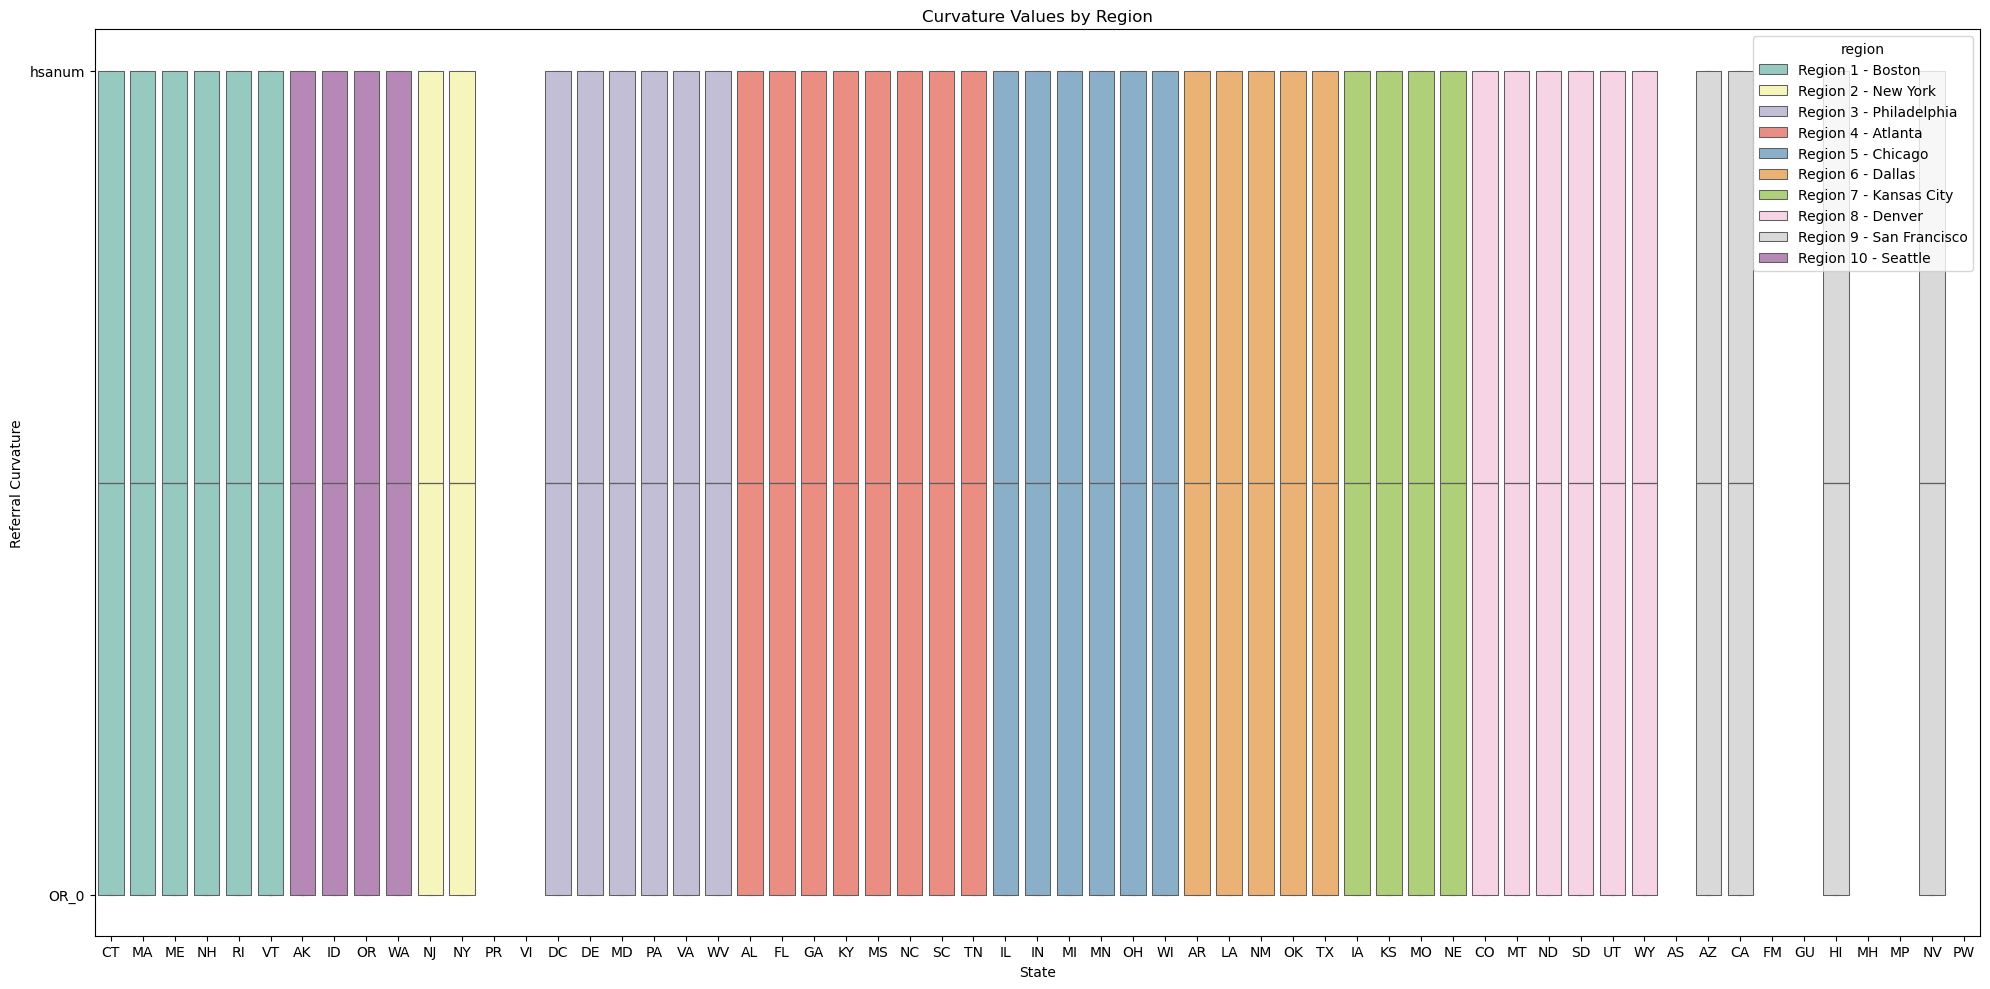

In [24]:
plt.figure(figsize=(20, 10))
sns.boxenplot(x='state', y='curvature', hue="region", data=melted_df, palette="Set3",hue_order=sorted_regions_array,order=ordered_states,)
plt.title('Curvature Values by Region')
plt.xlabel('State')
plt.ylabel('Referral Curvature')
plt.tight_layout()
plt.show()